<a href="https://colab.research.google.com/github/Computational-physics-with-learning/unsupervised-learning/blob/main/Deep-Image-Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning explanation from Chat-GPT 3


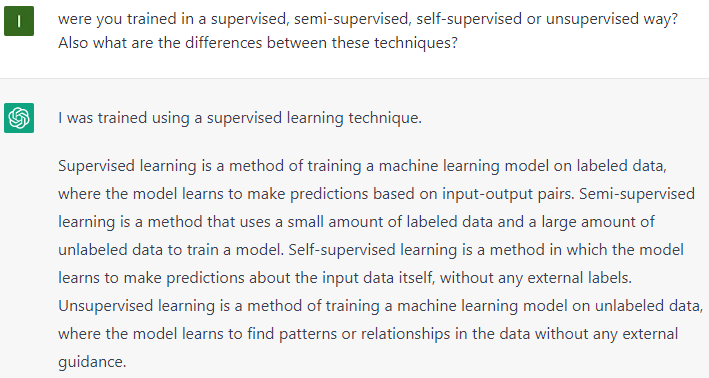

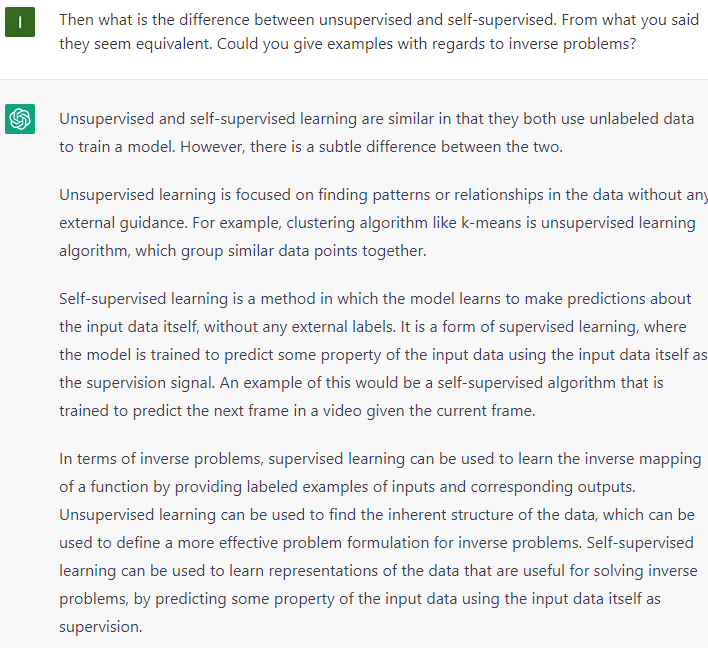

From Andrew Zisserman, who is a pioneer in the field of self-supervised learning, described self-supervised learning in a talk at ICML as:



> Self-supervised Learning is a form of unsupervised learning where the data provides the supervision. In general, we withhold some part of the data and task the network with predicting it. The network is forced to learn what we really care about e.g. a semantic representation, in order to solve it.

We focus on unsupervised learning rather than self-supervised. Specifically Deep Image Prior.

 # Deep Image Prior

 Originally for image denoising/inpainting/super-resolution. [Paper here.](https://arxiv.org/pdf/1711.10925.pdf)

Denoting a neural network $f_{\theta_0}(z)$ where $\theta_0$ are randomly initialised network weights/bias, and $z$ is a random input image (usually noise).

Given our reconstruction is given by $x = f_{\theta}(z)$, i.e. the output of the neural network. The network parameters are trained according to:

$$\min_{\theta}E( f_{\theta}(z), y)$$


Where $E$ is a function measuring the distance between the measurements/noisy image $y$ and reconstructed image $x = f_{\theta}(z)$. This function is usually MSE loss for Gaussian noise as this gives the maxiumum likelihood estimate.


# Why do this?

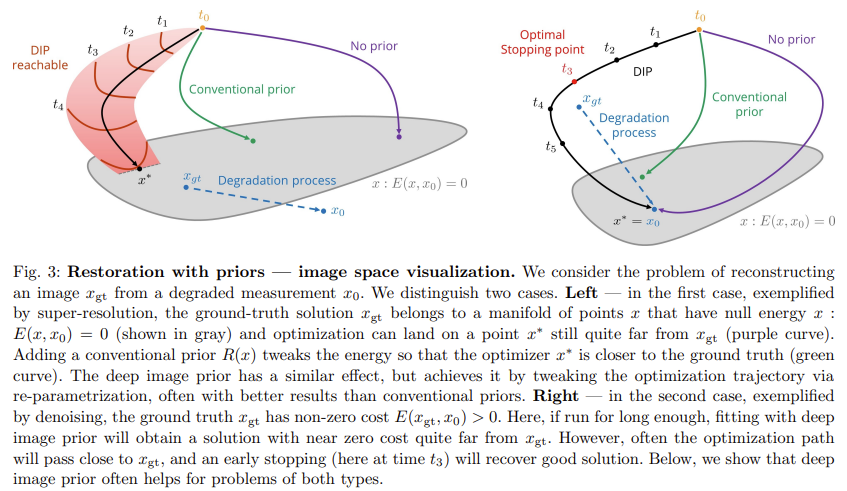

Essentially the concept is that through fitting the network parameters to output a reconstruction, the reconstruction fits the natural image faster than it fits the noise.

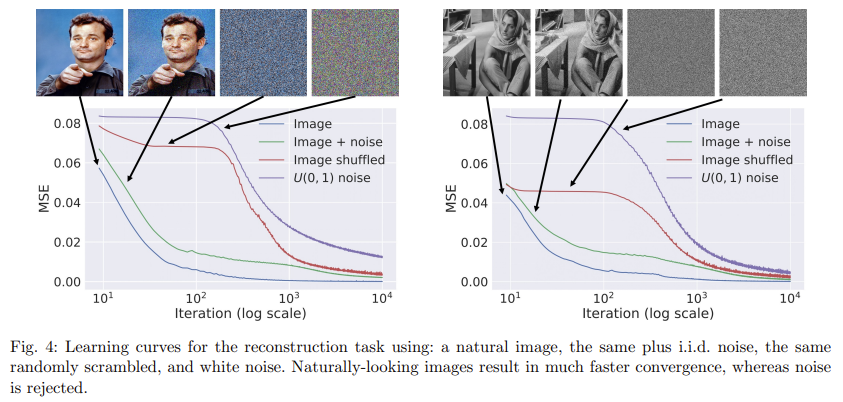

It is worth observing that denoising/super-resolution/inpainting are all linear inverse problems of the form: 

$$y = Ax$$

where measurements $y$, reconstructed image $x$ and forward operator $A$.

The most important considerations with Deep Image Prior are:



*   Network architecture (typically U-Net)
*   Optimisation procedure typically ADAM
*   Avoiding overfitting as network able to fit any image perfectly

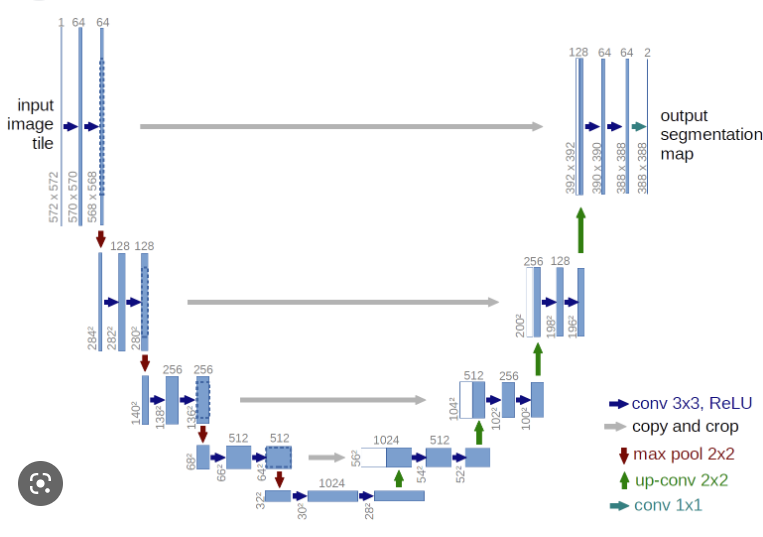



# Inverse problem in medical imaging

I work on PET/MRI image reconstruction, where the image reconstruction for each modality can be/is a linear inverse problem.

$y=Ax$

MRI is linear inverse problem with the forward operator is some fourier-type transform. Noise is complex additive white Gaussian noise.

PET is can be cast as a linear inverse problem too, with the forward operator is a radon-type transform. Noise is possion (photon counting).

These inverse problems are ill-posed in the sense hadamard; nonexistence, nonuniqueness and stability. The ill-posedness increases with increased undersampling/noise.

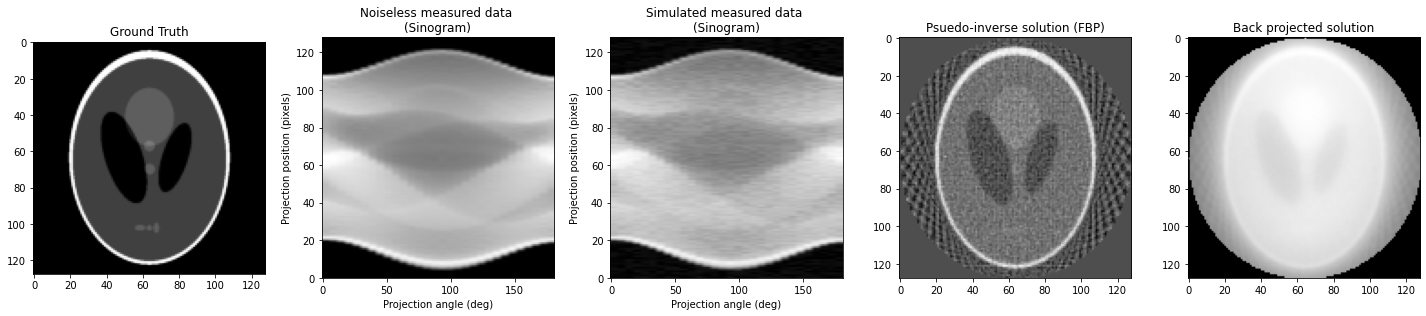

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

ground_truth = rescale(shepp_logan_phantom(), scale=128/400, mode='reflect')
views_theta = np.linspace(0., 180., 30, endpoint=False)
noiseless_measured = radon(ground_truth, theta=views_theta)
measured = noiseless_measured + np.random.rand(*noiseless_measured.shape)*2
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4.5))

ax1.set_title("Ground Truth")
ax1.imshow(ground_truth, cmap=plt.cm.Greys_r)

dx, dy = 0.5 * 180.0 / max(ground_truth.shape), 0.5 / ground_truth.shape[0]
ax2.set_title("Noiseless measured data \n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(noiseless_measured, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, noiseless_measured.shape[0] + dy),
           aspect='auto')
ax3.set_title("Simulated measured data \n(Sinogram)")
ax3.set_xlabel("Projection angle (deg)")
ax3.set_ylabel("Projection position (pixels)")
ax3.imshow(measured, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, noiseless_measured.shape[0] + dy),
           aspect='auto')
ax4.set_title("Psuedo-inverse solution (FBP)")
fbp = iradon(measured, theta=views_theta, filter_name='ramp', 
             interpolation='linear', circle=True, preserve_range=True)
ax4.imshow(fbp, cmap=plt.cm.Greys_r, aspect='auto')
ax5.set_title("Back projected solution")
ax5.imshow(iradon(measured, theta=views_theta, filter_name=None,
                  interpolation='linear', circle=True, preserve_range=True),
           cmap=plt.cm.Greys_r,
           aspect='auto')
fig.tight_layout()
plt.show()

# Deep Image Prior for Medical Image Reconstruction



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

ground_truth = rescale(shepp_logan_phantom(), scale=128/400, mode='reflect')
views_theta = np.linspace(0., 180., 30, endpoint=False)
noiseless_measured = radon(ground_truth, theta=views_theta)
measured = noiseless_measured + np.random.rand(*noiseless_measured.shape)*2

class radon_forward(torch.autograd.Function):
  @staticmethod
  def forward(ctx, image, views_theta):
    ctx.views_theta = views_theta
    out = torch.from_numpy(radon(image.detach().cpu().numpy(), theta=views_theta))
    out.requires_grad = True
    return out

  @staticmethod
  def backward(ctx, data):
    out = torch.from_numpy(iradon(data.detach().cpu().numpy(), \
                                  theta=ctx.views_theta, filter_name=None, \
                                  interpolation='linear', circle=True, \
                                  preserve_range=True))
    out.requires_grad = True
    return out, None

class ForwardPhysicalModel(torch.nn.Module):
  def __init__(self, views_theta):
    super(ForwardPhysicalModel, self).__init__()
    self.views_theta = views_theta

  def forward(self, x):
    return radon_forward.apply(x, self.views_theta)


fwdmodel = ForwardPhysicalModel(views_theta)

test = torch.from_numpy(np.zeros_like(ground_truth))
test.requires_grad = True

x = torch.nn.Parameter(test, requires_grad=True)
optim = torch.optim.Adam([x], lr=.1)
mse_qualities = []
for i in range(1000):
  optim.zero_grad()
  loss = (((fwdmodel(x) - torch.from_numpy(measured)).abs())**2).sum()
  loss.backward()
  optim.step()
  mse_quality = (((x - torch.from_numpy(ground_truth)).abs())**2).sum()
  mse_qualities.append(float(mse_quality.detach().numpy()))


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Decoder
        self.conv9 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv10 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv12 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv14 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv15 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x_skip_3 = self.conv2(x)
        x = self.pool1(x_skip_3)
        x = self.conv3(x)
        x_skip_2 = self.conv4(x)
        x = self.pool2(x_skip_2)
        x = self.conv5(x)
        x_skip_1 = self.conv6(x)
        x = self.pool3(x_skip_1)
        x = self.conv7(x)
        x = self.conv8(x)

        # Decoder
        x = self.conv9(x)
        x = self.upsample1(x)
        x = torch.cat([x, x_skip_1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)
        x = torch.cat([x, x_skip_2], dim=1)
        x = self.conv12(x)
        x = self.conv13(x)
        x = torch.cat([x, x_skip_3], dim=1)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)
        return x


(100, 200)

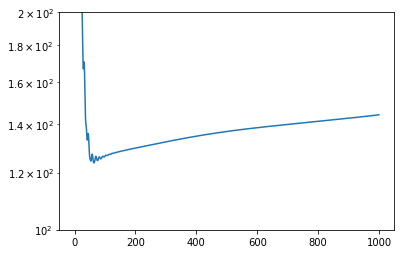

In [ ]:
plt.plot(list(range(1000)),mse_qualities)
plt.yscale("log")
plt.ylim([100,200])

# DIP for medical image reconstruction

The objective function changes to:

$$\min_{\theta}E( A f_{\theta}(z), y)$$

the function $E$ would be MSE for MRI and poisson negative log-likelihood/KL-divergence for PET.


For CT and MRI the forward operator is sufficiently ill-conditioned as we have a choice on the sampling procedure used. Typically we want shorter scan time/less radiation so we undersample. This means that the null-space is larger than a modality like PET where the acquisition is set due to scanner geometry and the reconstruction volume is larger.

CT/MRI are more compressive-sensing type problems where the forward operator is more ill-conditioned.

# DIP compressive-sensing type problems

It was argued in this paper [Compressive sensing with un-trained neural networks:
Gradient descent finds the smoothest approximation, Heckel and Soltanolkotabi, ICML 2020.](https://arxiv.org/pdf/2005.03991.pdf), that over-parameterised untrained convolutional networks have a "self-regularization
capability in the context of compressive sensing".



> In a nutshell, our main insight is that the behavior of large over-parameterized neural networks is dictated by the spectral properties of their Jacobian mapping. For the convolutional generators considered in this
paper, the associated Jacobian matrix has singular vectors that can be well approximated by the orthonormal trigonometric basis function and singular values that decay very quickly from the low-frequency to the highfrequency trigonometric basis functions. Specifically, the associated singular values decay approximately geometrically.

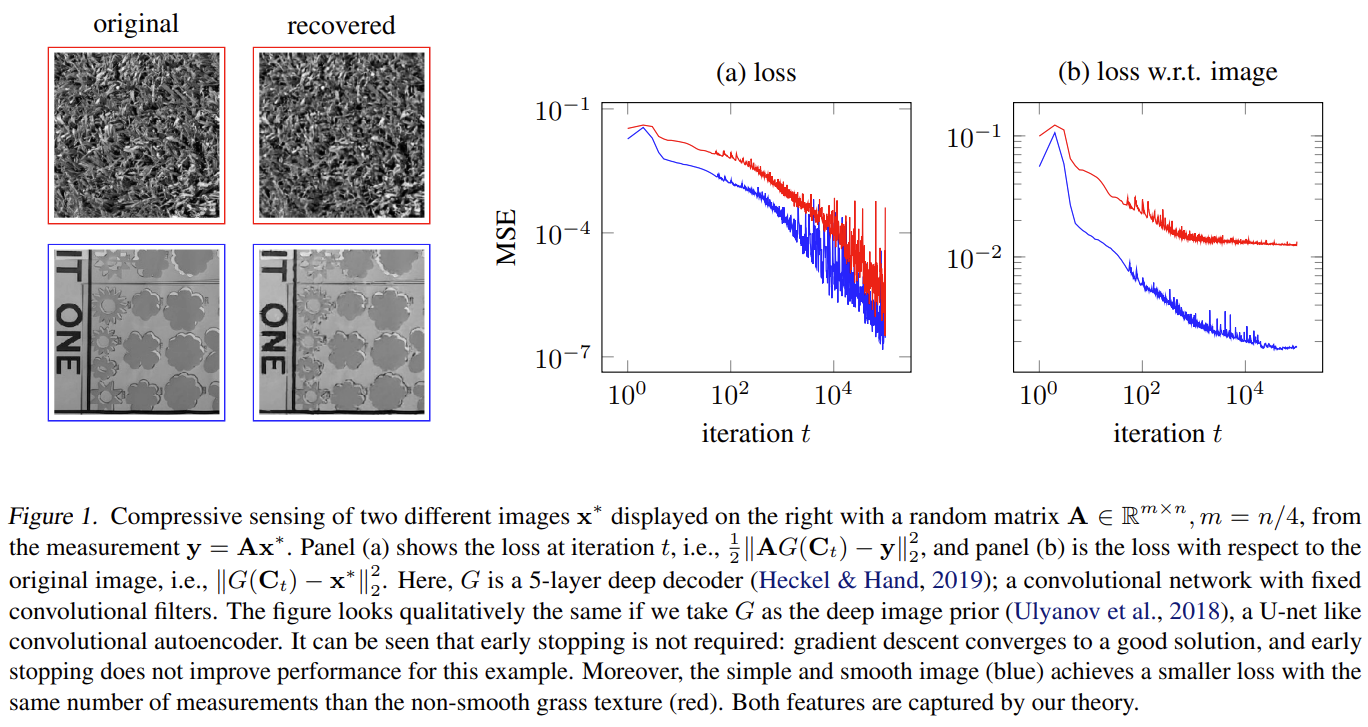



When actually solving these compressive type problems there is noise in the measurements.

To countact the noise traditional regularisation techniques (i.e. TV) are employed as well as DIP, so that there is not overfitting to noise.


$$\min_{\theta} E( A f_{\theta}(z), y) + λ TV(f_{\theta}(z))$$

overfitting preventing with TV whilst natural images promoted with DIP...

# Preventing overfitting



*   [Deep decoder](https://arxiv.org/pdf/1810.03982.pdf)
> Constraining the range-space of $f_θ(z)$ through under-parameterisation, meaning the network cannot represent noise.
*   [SURE-based constraint on DOF: Rethinking DIP paper](https://arxiv.org/pdf/2108.12841.pdf)
> SURE based loss essentially reducing the degrees of freedom with which the network could represent the signal.
*   [Early Stopping](https://openreview.net/pdf?id=JIl_kij_aov)
> Through tracking a metric based on the reconstructed network output, the variance of the output images through update iterations is tracked and is used as a stopping criteria for DIP.